In [62]:
# installation
!pip install imbalanced-learn scikit-learn catboost

In [63]:
# imports
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import kagglehub
from google.colab import drive
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import RocCurveDisplay
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from collections import Counter
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import warnings

In [64]:
# supress all warnings
warnings.filterwarnings('ignore')

# mounting drive
drive.mount('/content/drive')

# setting uo kaggle info
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/kaggle (1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# downloading dataset and its path
path = kagglehub.dataset_download("garystafford/environmental-sensor-data-132k")
print("Path to dataset files:", path)

# dataset files
os.listdir(path)

# cpopying dataset to working directory
shutil.copy(f'{path}/iot_telemetry_data.csv', '/content/iot_telemetry_data.csv')

# loading dataset
df = pd.read_csv('iot_telemetry_data.csv')

# checking null values, shape, description, and info
print(df.isnull().sum())
print(df.shape)
print(df.describe())
print(df.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Path to dataset files: /kaggle/input/environmental-sensor-data-132k
ts          0
device      0
co          0
humidity    0
light       0
lpg         0
motion      0
smoke       0
temp        0
dtype: int64
(405184, 9)
                 ts             co       humidity            lpg  \
count  4.051840e+05  405184.000000  405184.000000  405184.000000   
mean   1.594858e+09       0.004639      60.511694       0.007237   
std    1.994984e+05       0.001250      11.366489       0.001444   
min    1.594512e+09       0.001171       1.100000       0.002693   
25%    1.594686e+09       0.003919      51.000000       0.006456   
50%    1.594858e+09       0.004812      54.900000       0.007489   
75%    1.595031e+09       0.005409      74.300003       0.008150   
max    1.595203e+09       0.014420      99.900002       0.016567   

               smoke           temp  
c

Generating histograms


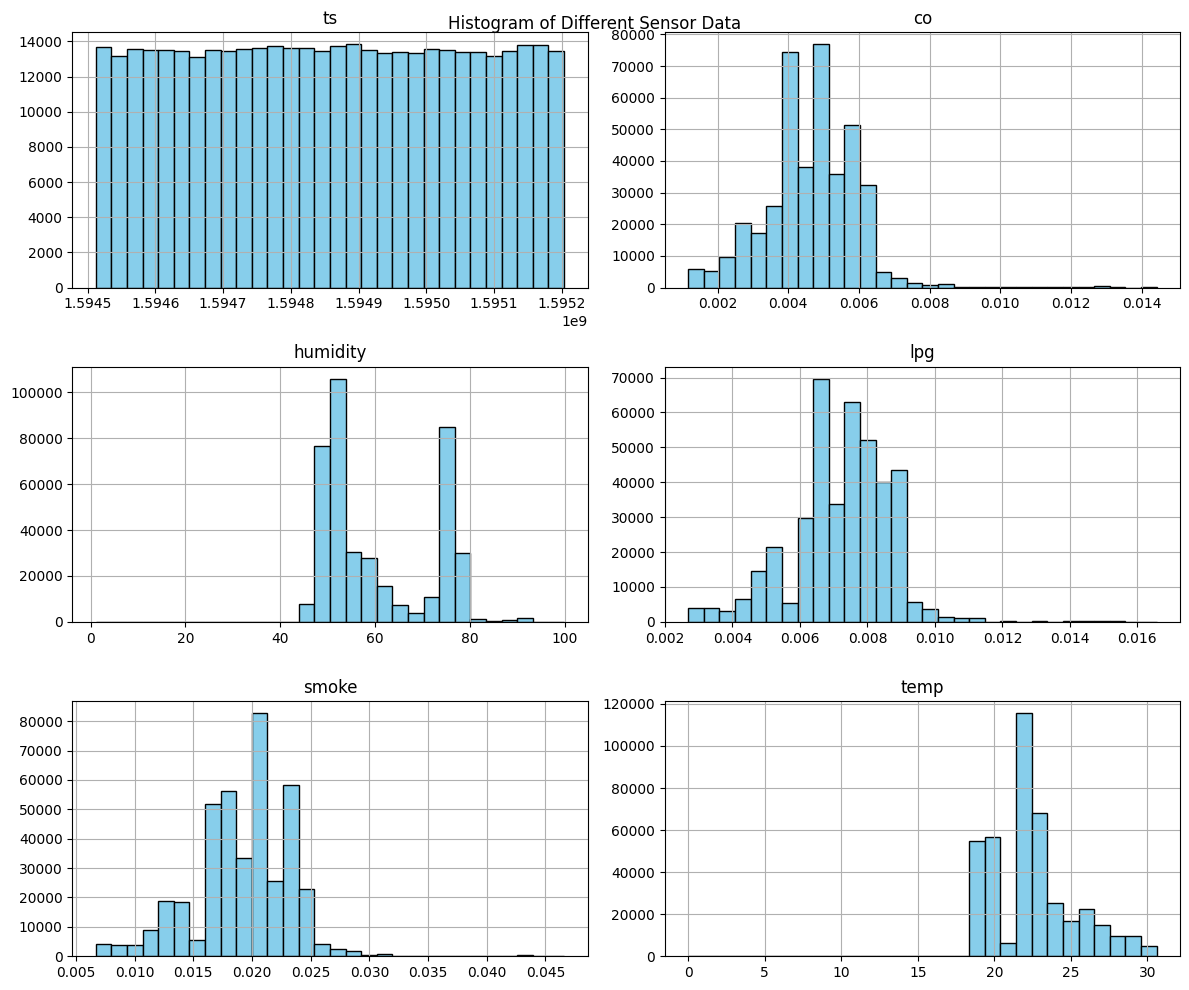


Generating box plots by device


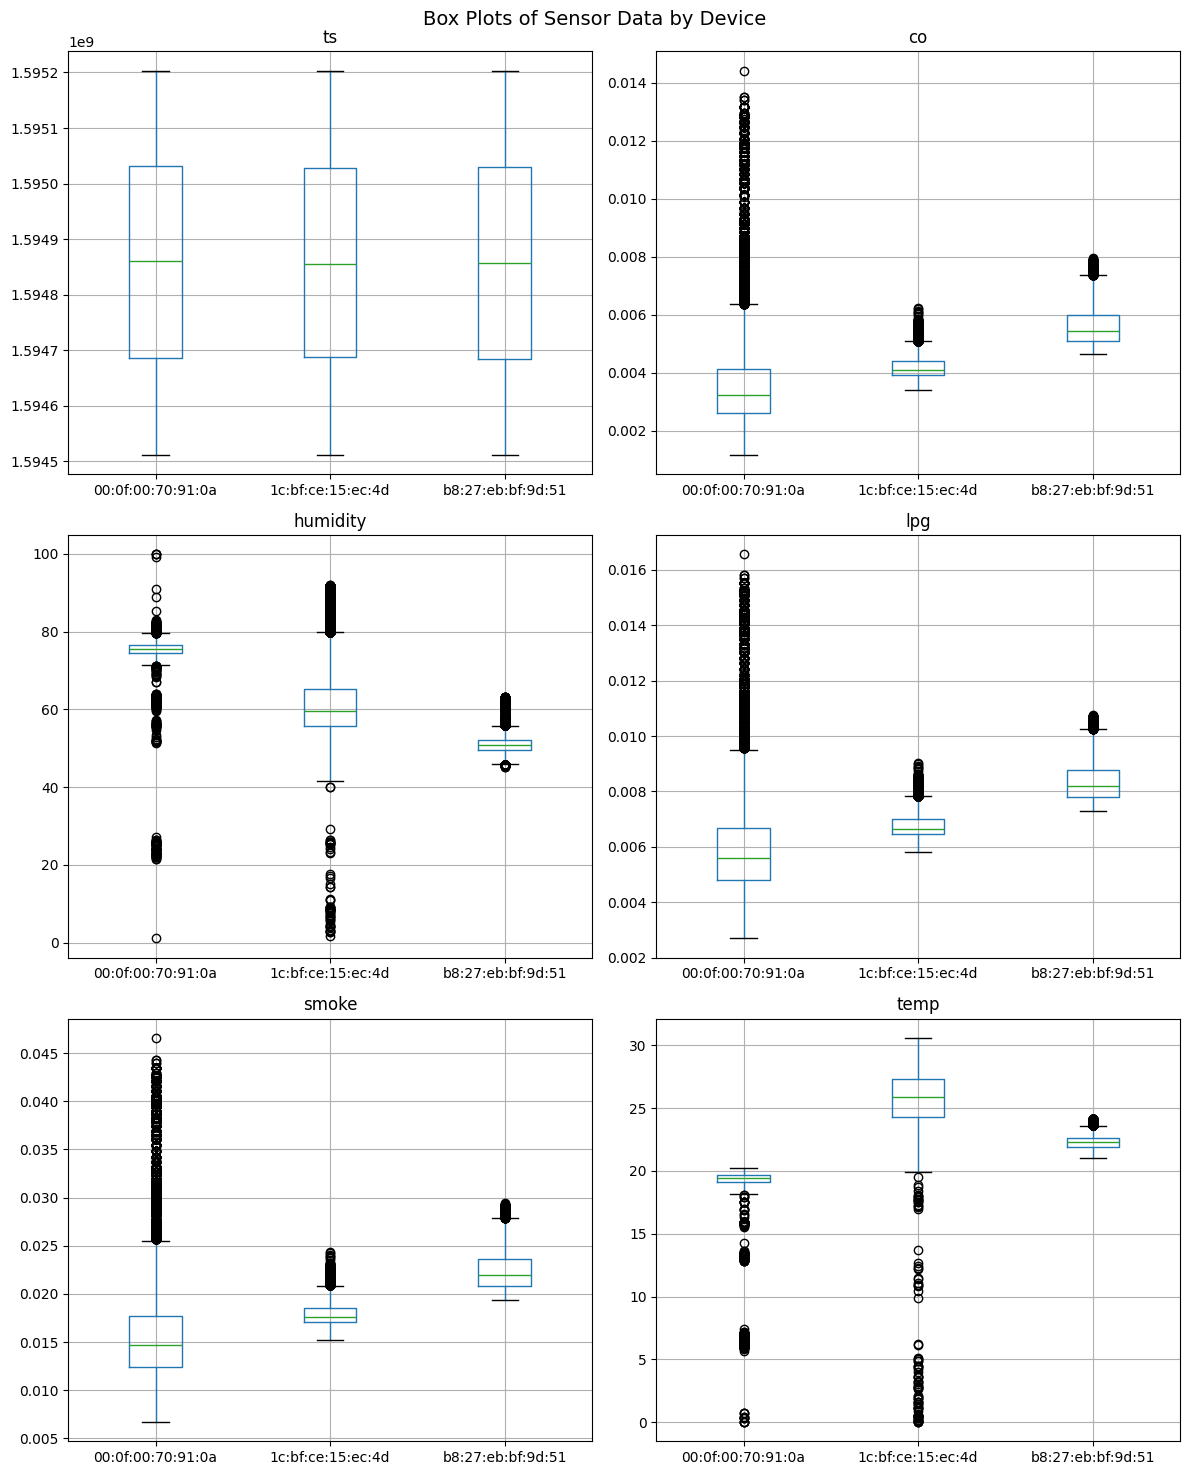


Generating daily temperature plots


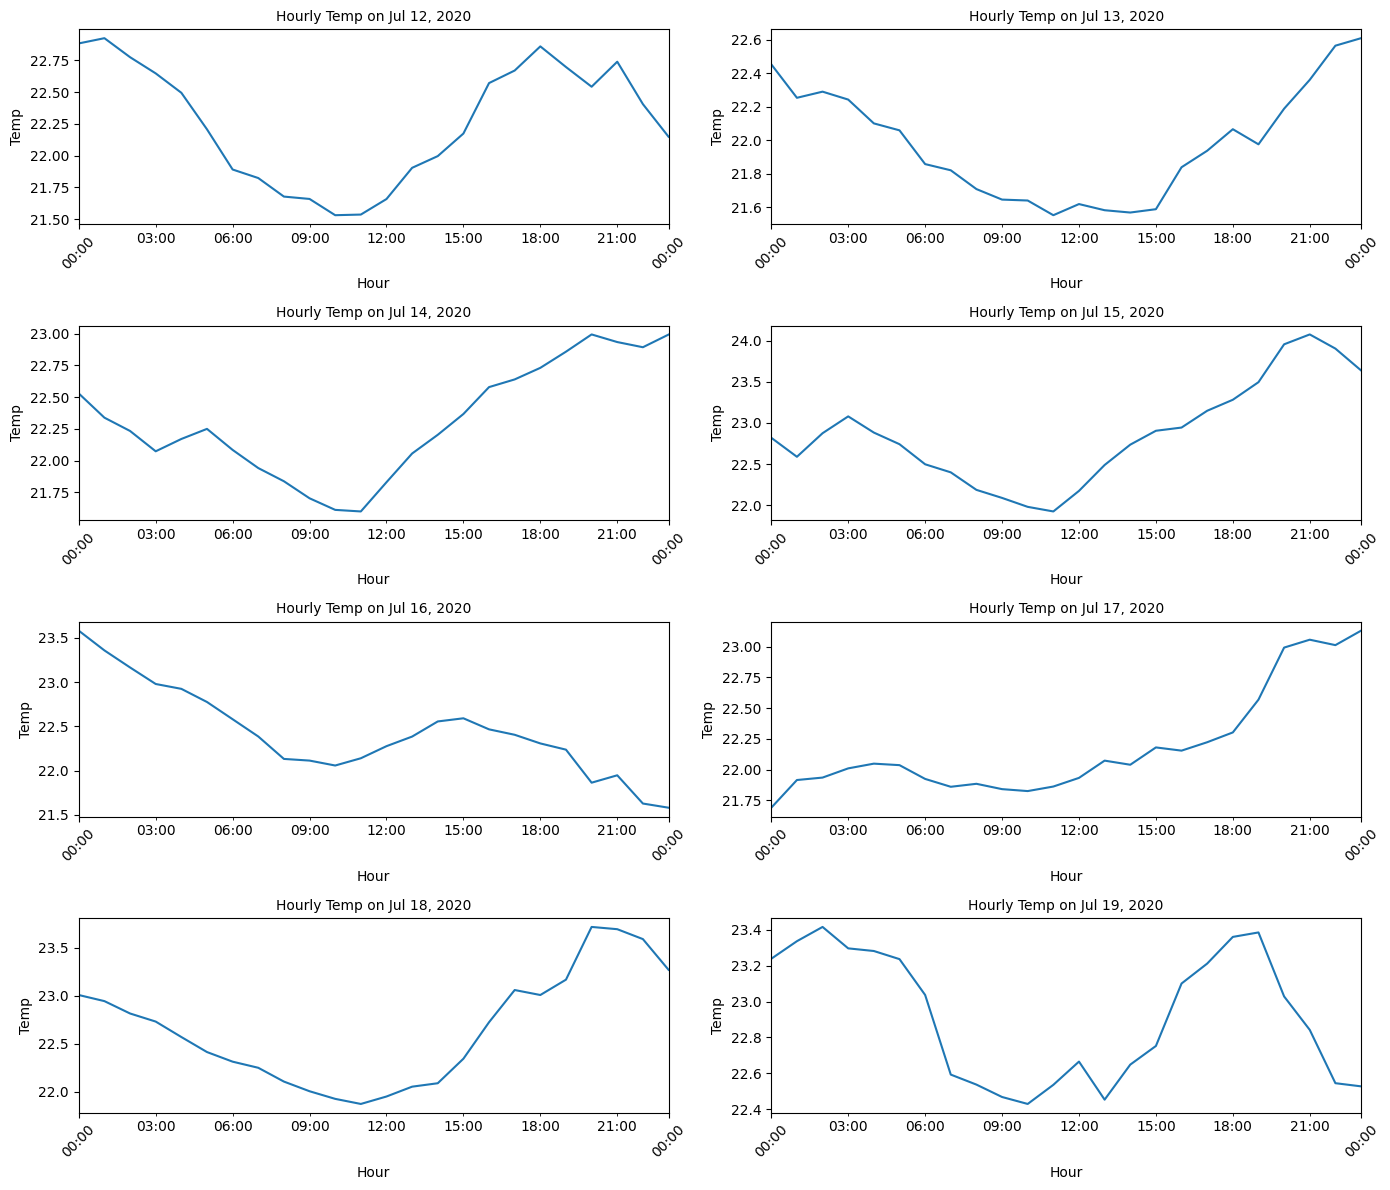


Generating scatter plots


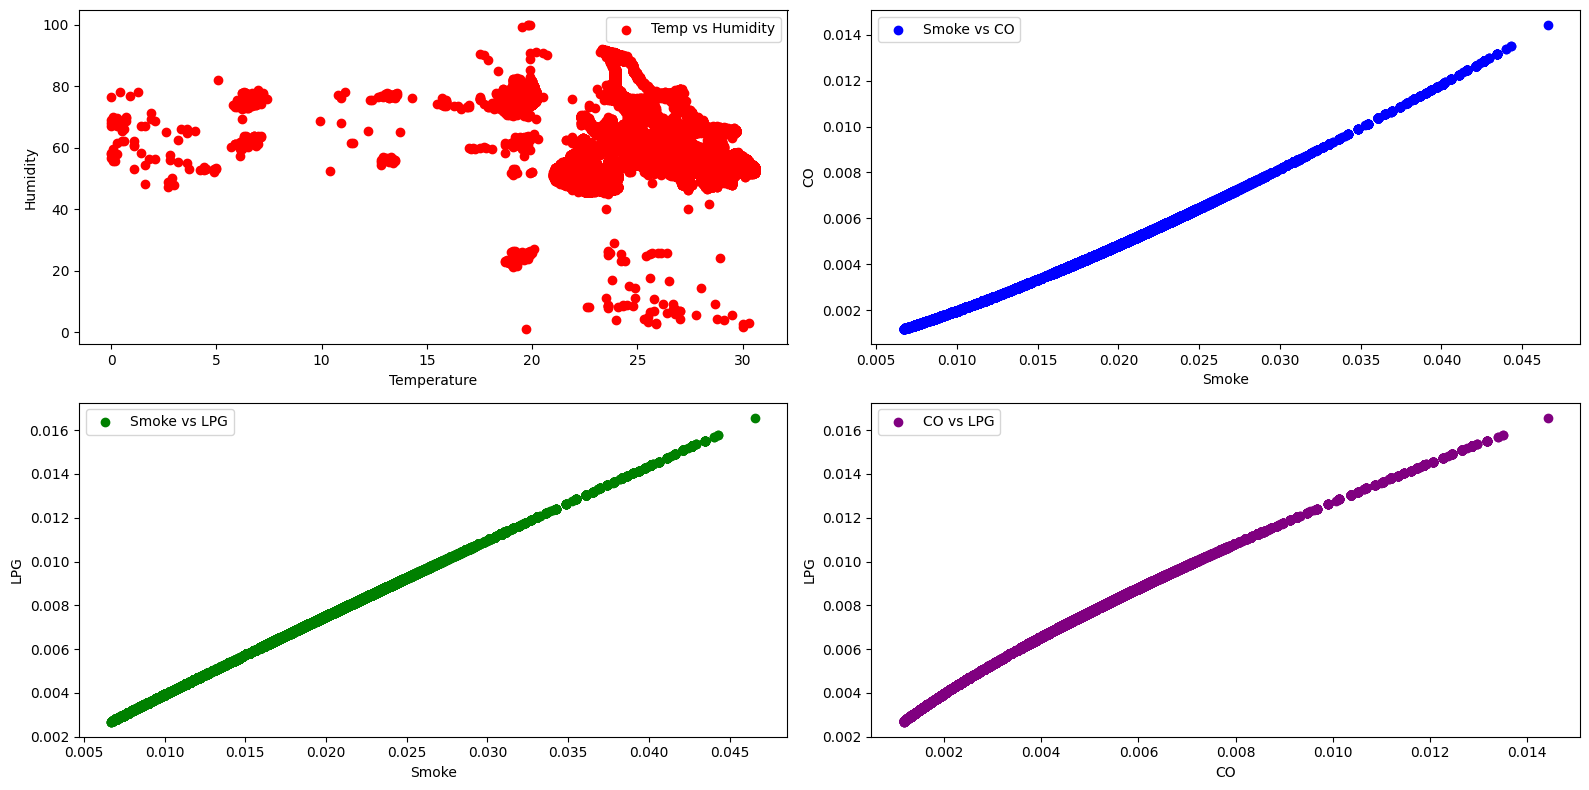


Generating correlation heatmap


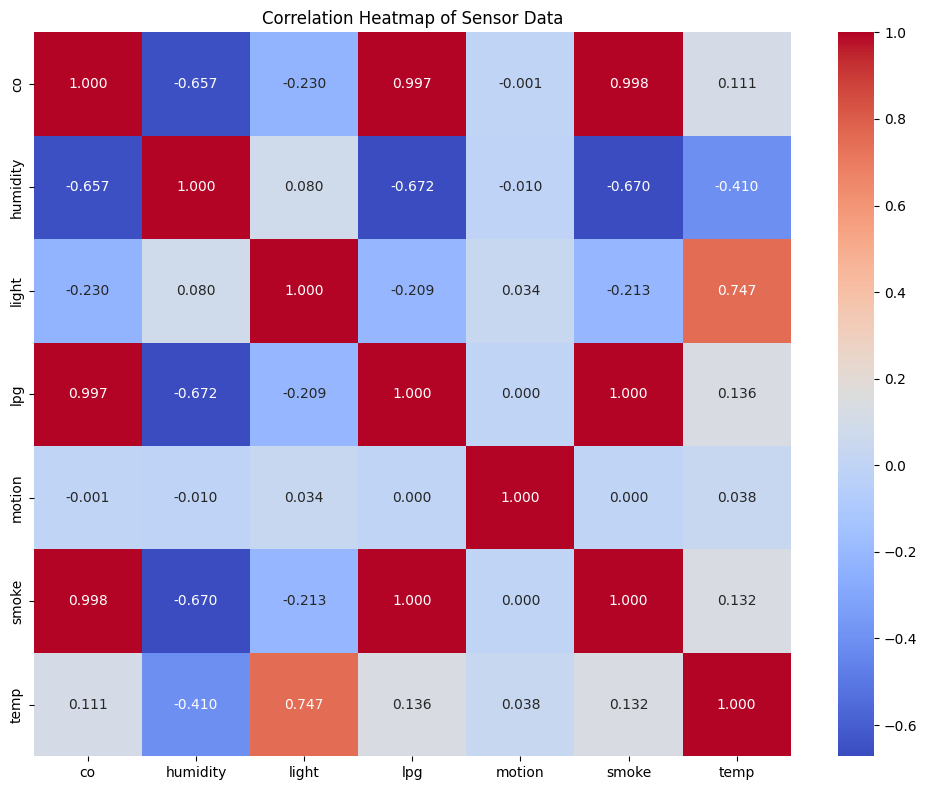


All visualizations completed and saved to 'plots/pre' directory!


In [65]:
# visualization of dataset

# creating directory
os.makedirs("plots/pre", exist_ok=True)

# histogram
print("Generating histograms")
numeric_cols = df.select_dtypes(include=['float64']).columns
df[numeric_cols].hist(numeric_cols, figsize=(12, 10), bins=30, color='skyblue', edgecolor='black')
plt.tight_layout()
plt.suptitle("Histogram of Different Sensor Data")
plt.savefig("plots/pre/histogram_sensor_data.png")
plt.show()

#boxplot
print("\nGenerating box plots by device")
cols = 2
rows = (len(numeric_cols) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    df.boxplot(ax=axes[i], by="device", column=col)
    axes[i].set_title(f'{col}', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# hiding if any unused axes exist
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Box Plots of Sensor Data by Device", fontsize=14)
plt.tight_layout()
plt.savefig("plots/pre/boxplot_sensor_data.png")
plt.show()

# daily hourly temperature plot
print("\nGenerating daily temperature plots")

# conversion of timestamps
if 'ts' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['ts']):
    df['ts'] = pd.to_datetime(df['ts'], unit='s')

# 8 subplots for 8 days
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 12))
axes = axes.flatten()

# looping through 8 days
for i in range(8):
    starting_date = '2020-07-12'
    date = pd.Timestamp(starting_date) + pd.Timedelta(days=i)
    df_day = df[(df['ts'] >= date) & (df['ts'] < date + pd.Timedelta(days=1))]

    df_day.set_index('ts')['temp'].resample('h').mean().plot(ax=axes[i])

    axes[i].set_title(f'Hourly Temp on {date.strftime("%b %d, %Y")}', fontsize=10)
    axes[i].set_xlabel('Hour')
    axes[i].set_ylabel('Temp')
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("plots/pre/daily_hourly_temp.png")
plt.show()

# scatter plot
print("\nGenerating scatter plots")
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

axes[0, 0].scatter(df['temp'], df['humidity'], color='red', label='Temp vs Humidity')
axes[0, 0].set_xlabel("Temperature")
axes[0, 0].set_ylabel("Humidity")
axes[0, 0].legend()

axes[0, 1].scatter(df['smoke'], df['co'], color='blue', label='Smoke vs CO')
axes[0, 1].set_xlabel("Smoke")
axes[0, 1].set_ylabel("CO")
axes[0, 1].legend()

axes[1, 0].scatter(df['smoke'], df['lpg'], color='green', label='Smoke vs LPG')
axes[1, 0].set_xlabel("Smoke")
axes[1, 0].set_ylabel("LPG")
axes[1, 0].legend()

axes[1, 1].scatter(df['co'], df['lpg'], color='purple', label='CO vs LPG')
axes[1, 1].set_xlabel("CO")
axes[1, 1].set_ylabel("LPG")
axes[1, 1].legend()

plt.tight_layout()
plot_path = 'plots/pre/scatter_plot.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

# correlation heatmap
print("\nGenerating correlation heatmap")
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".3f", cmap='coolwarm')
plt.title("Correlation Heatmap of Sensor Data")
plt.tight_layout()
plt.savefig('plots/pre/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAll visualizations completed and saved to 'plots/pre' directory!")

In [66]:
# feature engineering

# making a copy
df_encoded = df.copy()

df_encoded['ts'] = pd.to_datetime(df_encoded['ts'])

df_encoded['hour'] = df_encoded['ts'].dt.hour
df_encoded['dayofweek'] = df_encoded['ts'].dt.dayofweek
df_encoded['weekend'] = df_encoded['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

df_encoded['aqi'] = df_encoded['co'] + df_encoded['lpg'] + df_encoded['smoke']
df_encoded['potential_fire'] = df_encoded['smoke'] * df_encoded['temp']
df_encoded['humidity_temp_diff'] = df_encoded['humidity'] - df_encoded['temp']

# target label
threshold = 0.50
df_encoded['is_fire_risk'] = (df_encoded['potential_fire'] >= threshold).astype(int)
y = df_encoded['is_fire_risk']

df_encoded.head()

,ts,device,co,humidity,light,lpg,motion,smoke,temp,hour,dayofweek,weekend,aqi,potential_fire,humidity_temp_diff,is_fire_risk
0,2020-07-12 00:01:34.385974646,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000,0,6,1,0.033018,0.463336,28.300000,0
1,2020-07-12 00:01:34.735567570,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001,0,6,1,0.021229,0.261514,56.299999,0
2,2020-07-12 00:01:38.073572874,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000,0,6,1,0.033124,0.462738,28.300000,0
3,2020-07-12 00:01:39.589145899,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000,0,6,1,0.030055,0.502962,49.800003,1
4,2020-07-12 00:01:41.761234999,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000,0,6,1,0.033079,0.462116,28.300000,0


In [67]:
# encoding features
encoder = OneHotEncoder(sparse_output=False)
device_encoded = encoder.fit_transform(df_encoded[['device']])

# removing device column and adding encoded columns
encoded_cols = encoder.get_feature_names_out(['device'])
df_device_encoded = pd.DataFrame(device_encoded, columns=encoded_cols, index=df_encoded.index)

# binary encoding
df_encoded['motion'] = df_encoded['motion'].astype(int)
df_encoded['light'] = df_encoded['light'].astype(int)

# making new df with encoded features
df_encoded = pd.concat([df_encoded.drop(columns=['device']), df_device_encoded], axis=1)

# cyclic encoding of hour
df_encoded['hour_sin'] = np.sin(2 * np.pi * df_encoded['hour'] / 24)
df_encoded['hour_cos'] = np.cos(2 * np.pi * df_encoded['hour'] / 24)

# cyclic encoding of each day
df_encoded['day_sin'] = np.sin(2 * np.pi * df_encoded['dayofweek'] / 7)
df_encoded['day_cos'] = np.cos(2 * np.pi * df_encoded['dayofweek'] / 7)

# dropping original column after encoding
df_encoded = df_encoded.drop(columns=['hour', 'dayofweek'])

df_encoded.head()

,ts,co,humidity,light,lpg,motion,smoke,temp,weekend,aqi,potential_fire,humidity_temp_diff,is_fire_risk,device_00:0f:00:70:91:0a,device_1c:bf:ce:15:ec:4d,device_b8:27:eb:bf:9d:51,hour_sin,hour_cos,day_sin,day_cos
0,2020-07-12 00:01:34.385974646,0.004956,51.000000,0,0.007651,0,0.020411,22.700000,1,0.033018,0.463336,28.300000,0,0.0,0.0,1.0,0.0,1.0,-0.781831,0.62349
1,2020-07-12 00:01:34.735567570,0.002840,76.000000,0,0.005114,0,0.013275,19.700001,1,0.021229,0.261514,56.299999,0,1.0,0.0,0.0,0.0,1.0,-0.781831,0.62349
2,2020-07-12 00:01:38.073572874,0.004976,50.900000,0,0.007673,0,0.020475,22.600000,1,0.033124,0.462738,28.300000,0,0.0,0.0,1.0,0.0,1.0,-0.781831,0.62349
3,2020-07-12 00:01:39.589145899,0.004403,76.800003,1,0.007023,0,0.018628,27.000000,1,0.030055,0.502962,49.800003,1,0.0,1.0,0.0,0.0,1.0,-0.781831,0.62349
4,2020-07-12 00:01:41.761234999,0.004967,50.900000,0,0.007664,0,0.020448,22.600000,1,0.033079,0.462116,28.300000,0,0.0,0.0,1.0,0.0,1.0,-0.781831,0.62349


In [68]:
# splitting of dataset

clustering_features = [
    "co", "humidity", "light", "lpg", "motion",
    "hour_sin", "hour_cos", "day_sin", "day_cos", "weekend"
]

clustering_data = df_encoded[clustering_features]

# splitting into train + temp with target
X_train, X_temp, y_train, y_temp = train_test_split(
    clustering_data,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# splitting temp into validation and test with target
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

In [69]:
# scaling of dataset

numerical_cols = ["co", "humidity", "lpg"]
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# verifying class distribution
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print("\nValidation set class distribution:")
print(y_val.value_counts(normalize=True))
print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))

# verifying shapes as well
print(f"Train shapes - X: {X_train.shape}, y: {y_train.shape}")
print(f"Val shapes - X: {X_val.shape}, y: {y_val.shape}")
print(f"Test shapes - X: {X_test.shape}, y: {y_test.shape}")

Training set class distribution:
is_fire_risk
0    0.709863
1    0.290137
Name: proportion, dtype: float64

Validation set class distribution:
is_fire_risk
0    0.709862
1    0.290138
Name: proportion, dtype: float64

Test set class distribution:
is_fire_risk
0    0.709862
1    0.290138
Name: proportion, dtype: float64
Train shapes - X: (283628, 10), y: (283628,)
Val shapes - X: (60778, 10), y: (60778,)
Test shapes - X: (60778, 10), y: (60778,)


Numerical features: ['co', 'humidity', 'lpg']
Categorical features: ['motion', 'light', 'weekend']
Time features: ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']

Fitting PCA
Fitting ICA


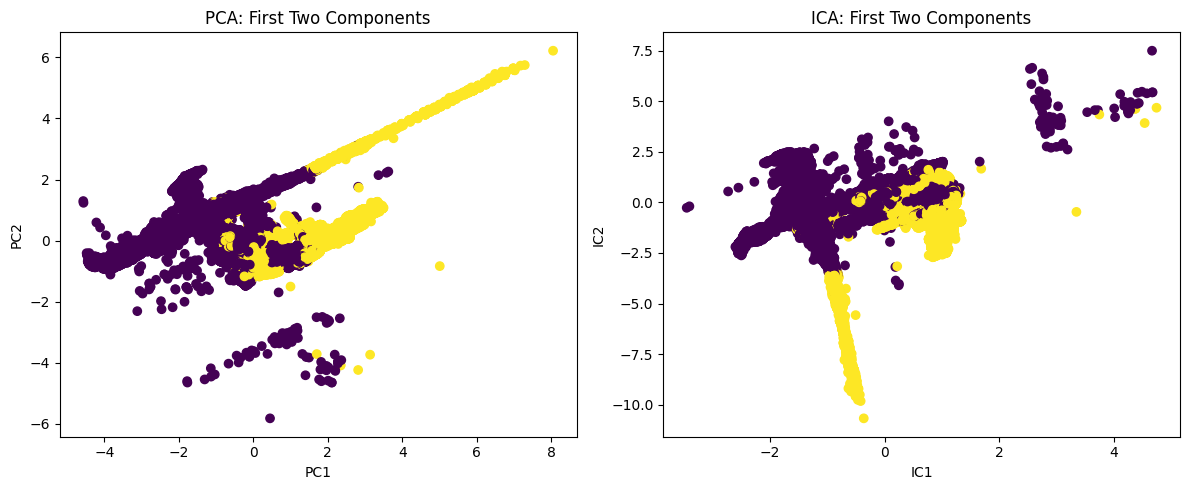

Results:
Explained variance ratios: [0.85386202 0.14531564]
Total explained variance: 0.9991776644116069
Final feature dimensions (PCA): 9
Final feature dimensions (ICA): 9


In [70]:
# dimensionality reduction comparision using PCA and ICA

# defining feature categories
numerical_cols = ["co", "humidity", "lpg"]
cat_cols = ['motion', 'light', 'weekend', 'cluster']
time_cols = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']

# veryfying columns
numerical_cols = [col for col in numerical_cols if col in X_train.columns]
cat_cols = [col for col in cat_cols if col in X_train.columns]
time_cols = [col for col in time_cols if col in X_train.columns]

print("Numerical features:", numerical_cols)
print("Categorical features:", cat_cols)
print("Time features:", time_cols)

# creating pipeline
pca_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42))
])

ica_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ica', FastICA(n_components=2, random_state=42, max_iter=1000))
])

# transforming numnerical features
print("\nFitting PCA")
X_train_pca = pca_pipe.fit_transform(X_train[numerical_cols])
X_val_pca = pca_pipe.transform(X_val[numerical_cols])
X_test_pca = pca_pipe.transform(X_test[numerical_cols])

print("Fitting ICA")
X_train_ica = ica_pipe.fit_transform(X_train[numerical_cols])
X_val_ica = ica_pipe.transform(X_val[numerical_cols])
X_test_ica = ica_pipe.transform(X_test[numerical_cols])

# visualizing reduced features
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
plt.title('PCA: First Two Components')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1, 2, 2)
plt.scatter(X_train_ica[:, 0], X_train_ica[:, 1], c=y_train, cmap='viridis')
plt.title('ICA: First Two Components')
plt.xlabel('IC1')
plt.ylabel('IC2')
plt.tight_layout()
plt.savefig('plots/pca_ica_visualization.png', dpi=300)
plt.show()

# combining time and numerical features
def combine_features(reduced_num, original_df, cat_cols, time_cols):
    features = [reduced_num]
    if cat_cols:
        features.append(original_df[cat_cols].values)
    if time_cols:
        features.append(original_df[time_cols].values)
    return np.hstack(features) if len(features) > 1 else reduced_num

X_train_pca_full = combine_features(X_train_pca, X_train, cat_cols, time_cols)
X_val_pca_full = combine_features(X_val_pca, X_val, cat_cols, time_cols)
X_test_pca_full = combine_features(X_test_pca, X_test, cat_cols, time_cols)

X_train_ica_full = combine_features(X_train_ica, X_train, cat_cols, time_cols)
X_val_ica_full = combine_features(X_val_ica, X_val, cat_cols, time_cols)
X_test_ica_full = combine_features(X_test_ica, X_test, cat_cols, time_cols)

# storing results
reduced_features = {
    "PCA": (X_train_pca_full, X_val_pca_full, X_test_pca_full),
    "ICA": (X_train_ica_full, X_val_ica_full, X_test_ica_full)
}

# checking results
print("Results:")
print("Explained variance ratios:", pca_pipe.named_steps['pca'].explained_variance_ratio_)
print("Total explained variance:", sum(pca_pipe.named_steps['pca'].explained_variance_ratio_))
print("Final feature dimensions (PCA):", X_train_pca_full.shape[1])
print("Final feature dimensions (ICA):", X_train_ica_full.shape[1])


Before resampling - Class distribution:
is_fire_risk
0    201337
1     82291
Name: count, dtype: int64


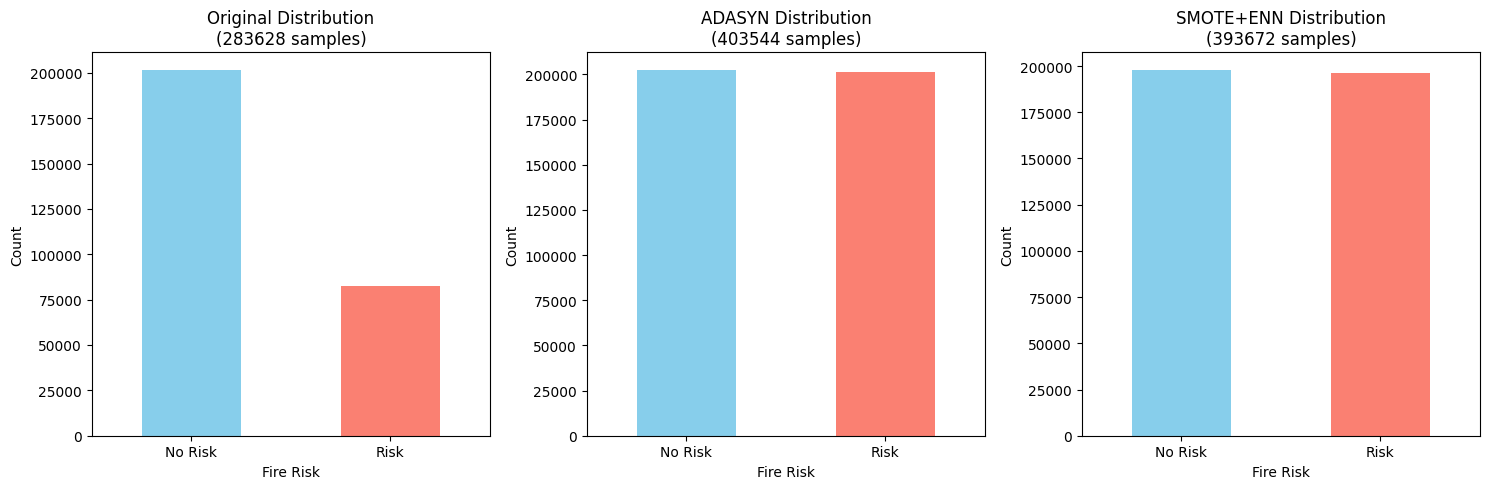


Resampling Results:

Original:
Total samples: 283628
is_fire_risk
0    0.709863
1    0.290137
Name: proportion, dtype: float64

ADASYN:
Total samples: 403544
is_fire_risk
1    0.501078
0    0.498922
Name: proportion, dtype: float64

SMOTE+ENN:
Total samples: 393672
is_fire_risk
0    0.502116
1    0.497884
Name: proportion, dtype: float64


In [71]:
# resampling

# verifying that there is no leakage of data
assert 'potential_fire' not in X_train.columns
assert 'smoke' not in X_train.columns
assert 'temp' not in X_train.columns

# appplying resampling to PCA-transformed data
print("\nBefore resampling - Class distribution:")
print(pd.Series(y_train).value_counts())

# ADASYN resampling
adasyn = ADASYN(random_state=42)
X_res_adasyn, y_res_adasyn = adasyn.fit_resample(X_train_pca_full, y_train)

# SMOTEENN resampling
smote_enn = SMOTEENN(random_state=42)
X_res_smoteenn, y_res_smoteenn = smote_enn.fit_resample(X_train_pca_full, y_train)

# analyzing results
resampling_results = {
    "Original": y_train,
    "ADASYN": y_res_adasyn,
    "SMOTE+ENN": y_res_smoteenn
}

plt.figure(figsize=(15, 5))
for i, (method, labels) in enumerate(resampling_results.items()):
    plt.subplot(1, 3, i+1)
    pd.Series(labels).value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title(f"{method} Distribution\n({len(labels)} samples)")
    plt.xlabel("Fire Risk")
    plt.ylabel("Count")
    plt.xticks([0, 1], ['No Risk', 'Risk'], rotation=0)
plt.tight_layout()
plt.savefig('plots/resampling_comparison.png', dpi=300)
plt.show()

# printing stats
print("\nResampling Results:")
for method, labels in resampling_results.items():
    print(f"\n{method}:")
    print(f"Total samples: {len(labels)}")
    print(pd.Series(labels).value_counts(normalize=True))

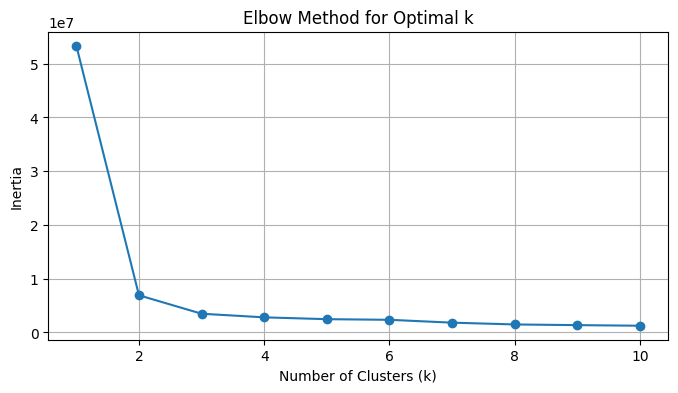

In [72]:
# appropriate number of clusters using elbow method

clustering_features = [
    "co", "humidity", "light", "lpg", "motion",
    "hour_sin", "hour_cos", "day_sin", "day_cos", "weekend"
]

clustering_data = df_encoded[clustering_features]
scaler = StandardScaler()

# only numerical features
clustering_data_scaled = clustering_data.copy()
clustering_data_scaled[numerical_cols] = scaler.fit_transform(clustering_data[numerical_cols])

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data)
    inertia.append(kmeans.inertia_)

# plotting the elbow graph
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plot_path = 'plots/pre/elbow.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

Plot saved to plots/clustering_comparison.png


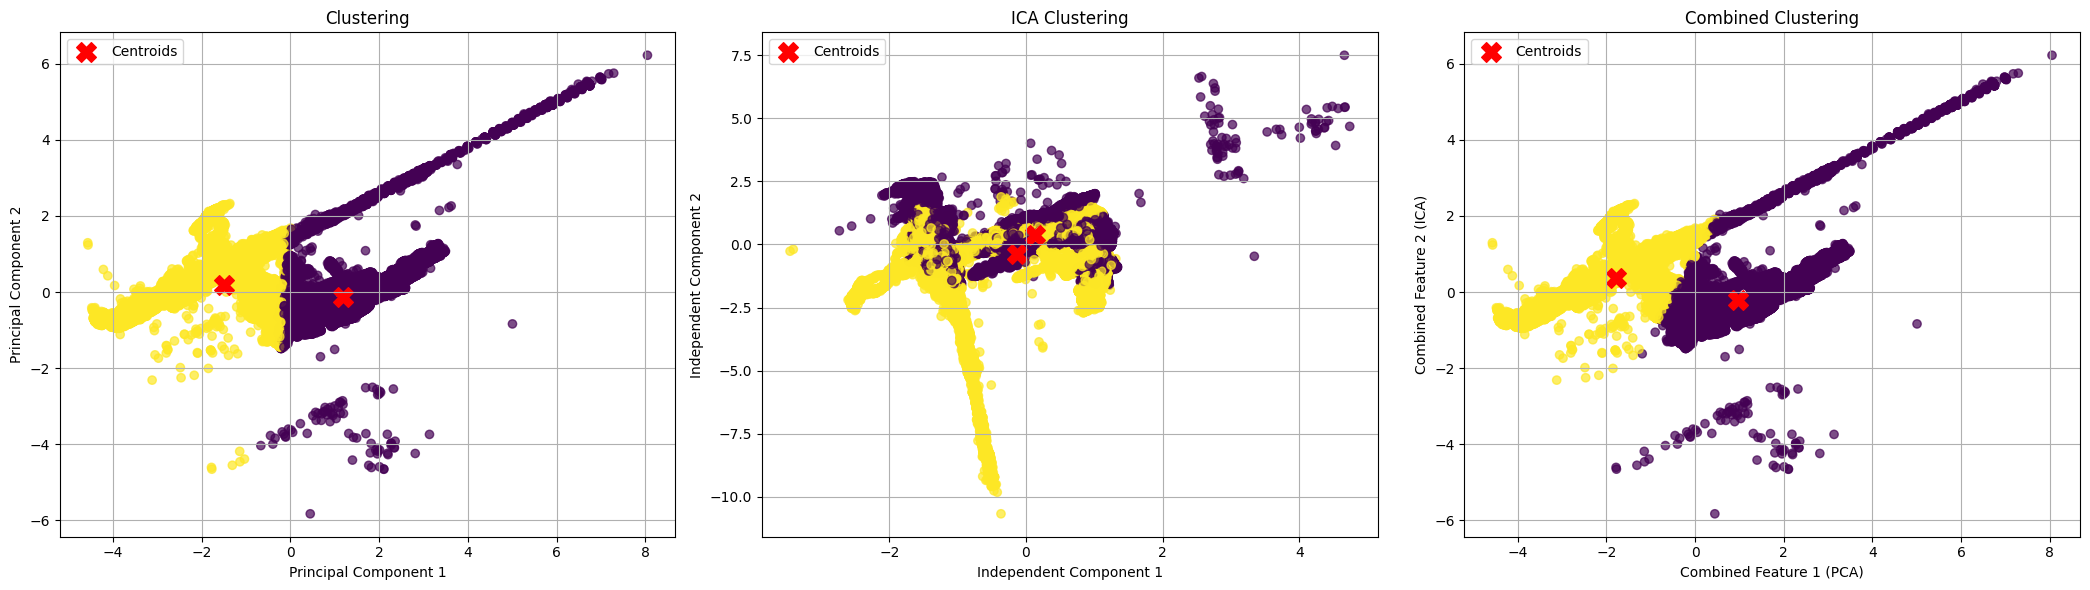


Cluster Distribution (PCA):
0    0.556997
1    0.443003
Name: proportion, dtype: float64

Cluster Distribution (ICA):
1    0.518958
0    0.481042
Name: proportion, dtype: float64

Cluster Distribution (Combined):
0    0.648621
1    0.351379
Name: proportion, dtype: float64


In [73]:
# k-means clustering from both ICA and PCA
os.makedirs('plots', exist_ok=True)

# clustering with PCA using the FULL features including categoricals
kmeans_pca = KMeans(n_clusters=2, random_state=42, n_init='auto')
labels_pca = kmeans_pca.fit_predict(X_train_pca_full)
centroids_pca = kmeans_pca.cluster_centers_

# cluster labels for all sets
y_train_pca = labels_pca
y_val_pca_labels = kmeans_pca.predict(X_val_pca_full)
y_test_pca_labels = kmeans_pca.predict(X_test_pca_full)

# clustering with ICA using the fULL features
kmeans_ica = KMeans(n_clusters=2, random_state=42, n_init='auto')
labels_ica = kmeans_ica.fit_predict(X_train_ica_full)
centroids_ica = kmeans_ica.cluster_centers_

# combined PCA + ICA features
X_combined = np.hstack([X_train_pca_full[:, :2], X_train_ica_full[:, :2]])
kmeans_combined = KMeans(n_clusters=2, random_state=42, n_init='auto')
labels_combined = kmeans_combined.fit_predict(X_combined)
centroids_combined = kmeans_combined.cluster_centers_

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# PCA plot
scatter_pca = axes[0].scatter(X_train_pca_full[:, 0], X_train_pca_full[:, 1],
                        c=labels_pca, cmap='viridis', alpha=0.7)
axes[0].scatter(centroids_pca[:, 0], centroids_pca[:, 1],
           c='red', marker='X', s=200, label='Centroids')
axes[0].set_title("Clustering")
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")
axes[0].legend()
axes[0].grid(True)

# ICA plot
scatter_ica = axes[1].scatter(X_train_ica_full[:, 0], X_train_ica_full[:, 1],
                             c=labels_ica, cmap='viridis', alpha=0.7)
axes[1].scatter(centroids_ica[:, 0], centroids_ica[:, 1],
               c='red', marker='X', s=200, label='Centroids')
axes[1].set_title(f"ICA Clustering")
axes[1].set_xlabel("Independent Component 1")
axes[1].set_ylabel("Independent Component 2")
axes[1].legend()
axes[1].grid(True)

# combined features plot
scatter_combined = axes[2].scatter(X_combined[:, 0], X_combined[:, 1],
                                  c=labels_combined, cmap='viridis', alpha=0.7)
axes[2].scatter(centroids_combined[:, 0], centroids_combined[:, 1],
               c='red', marker='X', s=200, label='Centroids')
axes[2].set_title(f"Combined Clustering")
axes[2].set_xlabel("Combined Feature 1 (PCA)")
axes[2].set_ylabel("Combined Feature 2 (ICA)")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()

plot_path = 'plots/clustering_comparison.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to {plot_path}")
plt.show()

# printing cluster distribution
print("\nCluster Distribution (PCA):")
print(pd.Series(y_train_pca).value_counts(normalize=True))

print("\nCluster Distribution (ICA):")
print(pd.Series(labels_ica).value_counts(normalize=True))

print("\nCluster Distribution (Combined):")
print(pd.Series(labels_combined).value_counts(normalize=True))

In [74]:
# defining the training and evaluation function
def evaluate_and_compare_model(model, model_name, X_train_resampled, y_train_resampled,
                              X_val_transformed, y_val_true, X_test_transformed, y_test_true,
                              X_train_pca_for_kmeans, labels_pca_train_kmeans, centroids_pca):
    model.fit(X_train_resampled, y_train_resampled)
    y_val_pred = model.predict(X_val_transformed)
    y_test_pred = model.predict(X_test_transformed)

    if hasattr(model, 'predict_proba'):
        val_probabilities = model.predict_proba(X_val_transformed)
        test_probabilities = model.predict_proba(X_test_transformed)
        val_roc_auc = roc_auc_score(y_val_true, val_probabilities[:, 1])
        test_roc_auc = roc_auc_score(y_test_true, test_probabilities[:, 1])
    else:
        val_probabilities = None
        test_probabilities = None
        val_roc_auc = None
        test_roc_auc = None

    metrics = {
        'model_name': model_name,
        'model': model,
        'val_accuracy': accuracy_score(y_val_true, y_val_pred),
        'val_precision': precision_score(y_val_true, y_val_pred),
        'val_recall': recall_score(y_val_true, y_val_pred),
        'val_f1': f1_score(y_val_true, y_val_pred),
        'val_roc_auc': val_roc_auc,
        'test_accuracy': accuracy_score(y_test_true, y_test_pred),
        'test_precision': precision_score(y_test_true, y_test_pred),
        'test_recall': recall_score(y_test_true, y_test_pred),
        'test_f1': f1_score(y_test_true, y_test_pred),
        'test_roc_auc': test_roc_auc,
        'val_confusion_matrix': confusion_matrix(y_val_true, y_val_pred),
        'test_confusion_matrix': confusion_matrix(y_test_true, y_test_pred),
        'test_probabilities': test_probabilities
    }

    print(f"\n{model_name} Validation Classification Report:")
    print(classification_report(y_val_true, y_val_pred))
    print(f"\n{model_name} Test Classification Report:")
    print(classification_report(y_test_true, y_test_pred))

    return metrics

In [75]:
# defining the models
models = [
    {
        'model': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
        'name': 'Logistic Regression'
    },
    {
        'model': KNeighborsClassifier(n_neighbors=5),
        'name': 'KNN'
    },
    {
        'model': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        'name': 'Random Forest'
    },
    {
        'model': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        'name': 'XGBoost'
    },
    {
        'model': lgb.LGBMClassifier(random_state=42,verbose=-1, class_weight='balanced'),
        'name': 'LightGBM'
    },
    {
        'model': CatBoostClassifier(random_state=42, verbose=0, auto_class_weights='Balanced'),
        'name': 'CatBoost'
    }
]

In [76]:
#evaluation of models

# creating directories for saving results and plots
os.makedirs('results', exist_ok=True)

results_list = []
for model_info in models:
    model = model_info['model']
    model_name = model_info['name']

    print(f"\nEvaluating {model_name}")

    # evaluating model
    results = evaluate_and_compare_model(
        model=model,
        model_name=model_name,
        X_train_resampled=X_res_adasyn,
        y_train_resampled=y_res_adasyn,
        X_val_transformed=X_val_pca_full,
        y_val_true=y_val,
        X_test_transformed=X_test_pca_full,
        y_test_true=y_test,
        X_train_pca_for_kmeans=X_train_pca_full,
        labels_pca_train_kmeans=labels_pca,
        centroids_pca=centroids_pca
    )

    results_list.append(results)

results_df = pd.DataFrame([{
    'Model': r['model_name'],
    'Val Accuracy': r['val_accuracy'],
    'Val Precision': r['val_precision'],
    'Val Recall': r['val_recall'],
    'Val F1': r['val_f1'],
    'Val ROC AUC': r['val_roc_auc'],
    'Test Accuracy': r['test_accuracy'],
    'Test Precision': r['test_precision'],
    'Test Recall': r['test_recall'],
    'Test F1': r['test_f1'],
    'Test ROC AUC': r['test_roc_auc']
} for r in results_list])

# saving summary to CSV
results_df.to_csv('results/model_comparison.csv', index=False)
print("\nModel Comparison Summary:")
print(results_df)


Evaluating Logistic Regression

Logistic Regression Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     43144
           1       0.75      0.96      0.84     17634

    accuracy                           0.90     60778
   macro avg       0.87      0.91      0.88     60778
weighted avg       0.91      0.90      0.90     60778


Logistic Regression Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     43144
           1       0.75      0.96      0.84     17634

    accuracy                           0.90     60778
   macro avg       0.87      0.91      0.88     60778
weighted avg       0.91      0.90      0.90     60778


Evaluating KNN

KNN Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     43144
           1       0.95      0.99      0.97   

<Figure size 600x600 with 0 Axes>

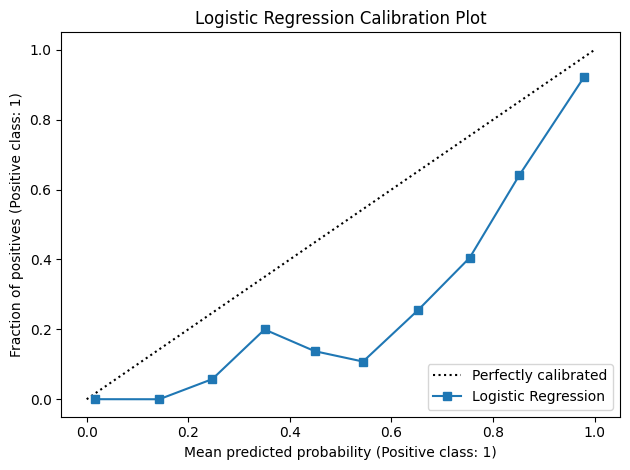

Saved predictions to results/logistic_regression_predictions.csv


<Figure size 600x600 with 0 Axes>

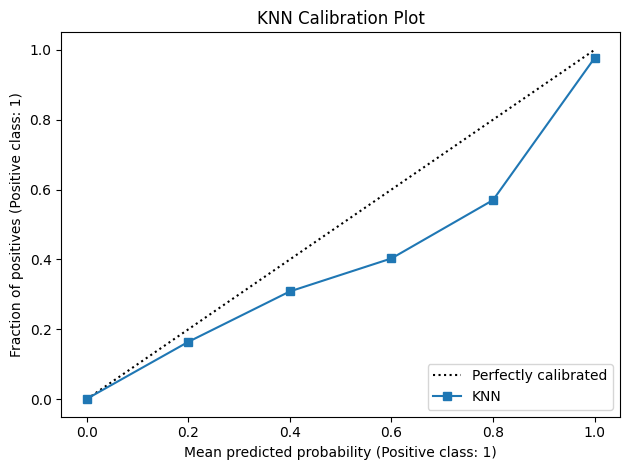

Saved predictions to results/knn_predictions.csv


<Figure size 600x600 with 0 Axes>

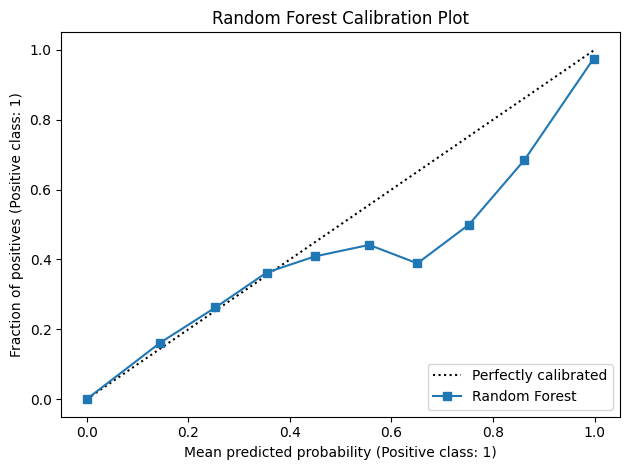

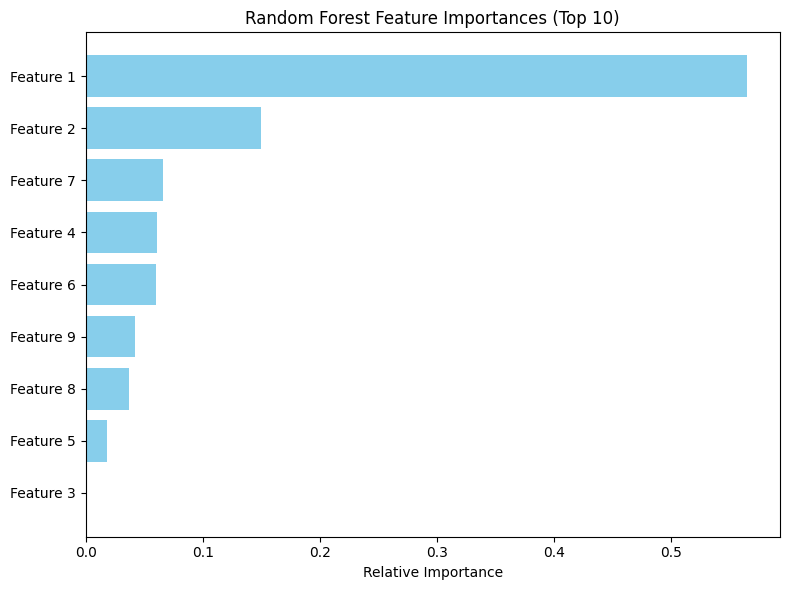

Saved predictions to results/random_forest_predictions.csv


<Figure size 600x600 with 0 Axes>

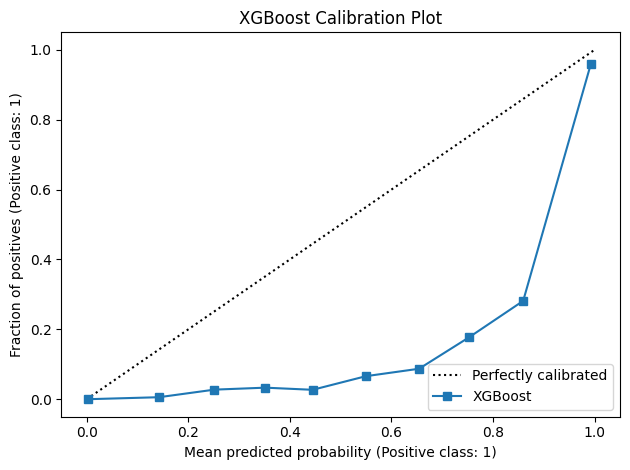

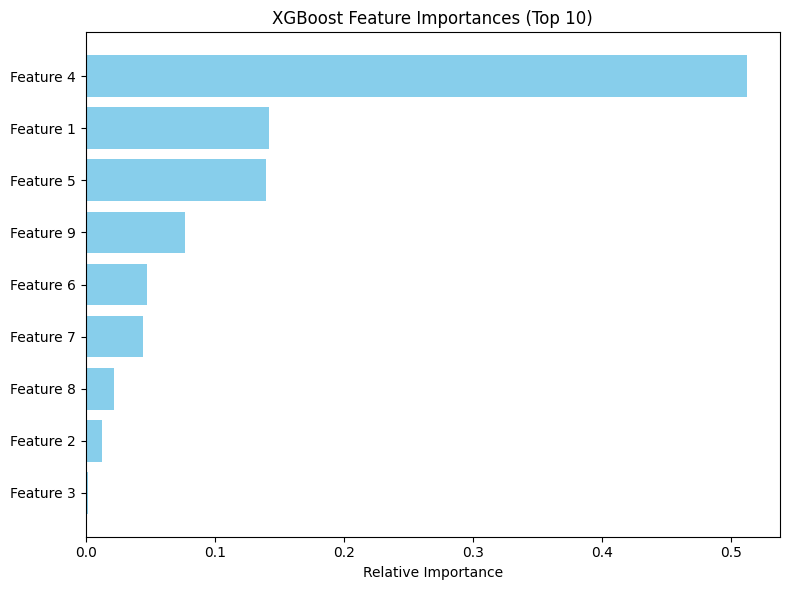

Saved predictions to results/xgboost_predictions.csv


<Figure size 600x600 with 0 Axes>

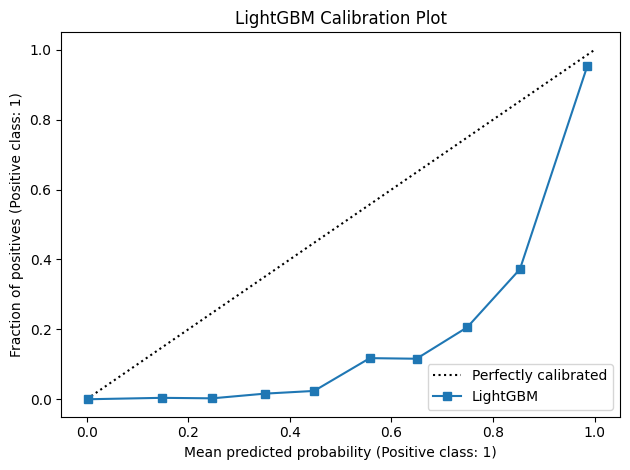

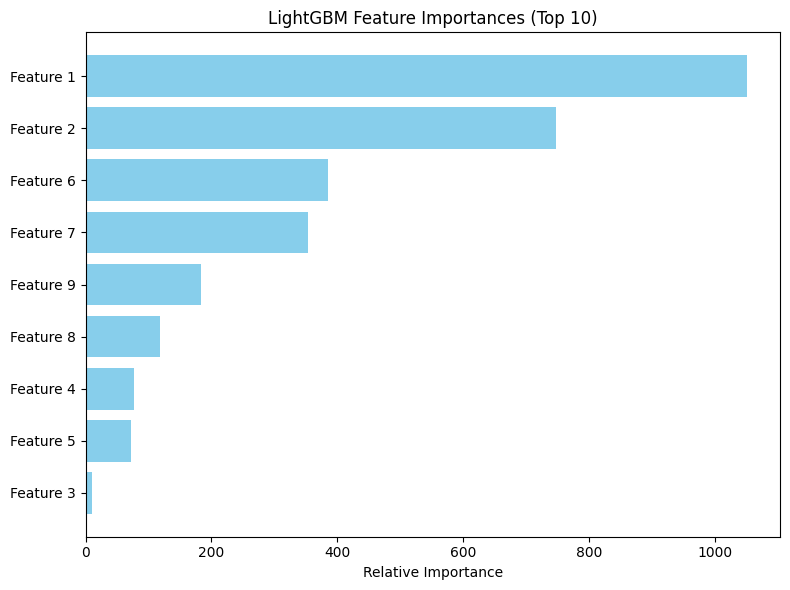

Saved predictions to results/lightgbm_predictions.csv


<Figure size 600x600 with 0 Axes>

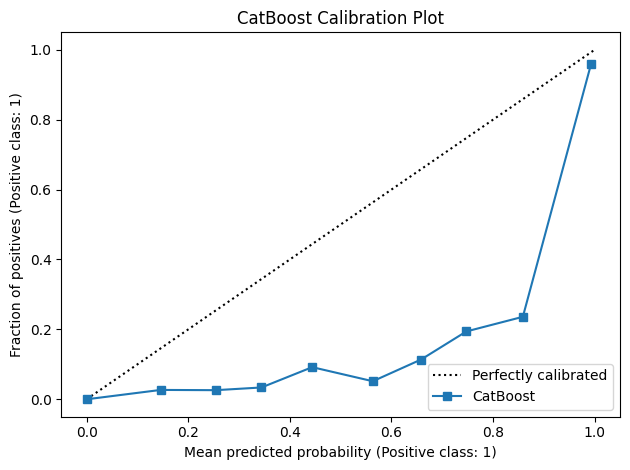

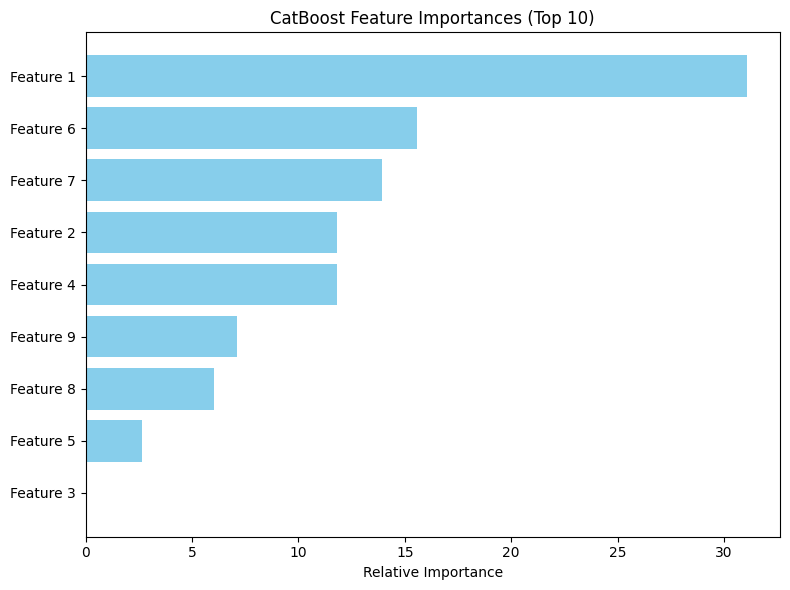

Saved predictions to results/catboost_predictions.csv


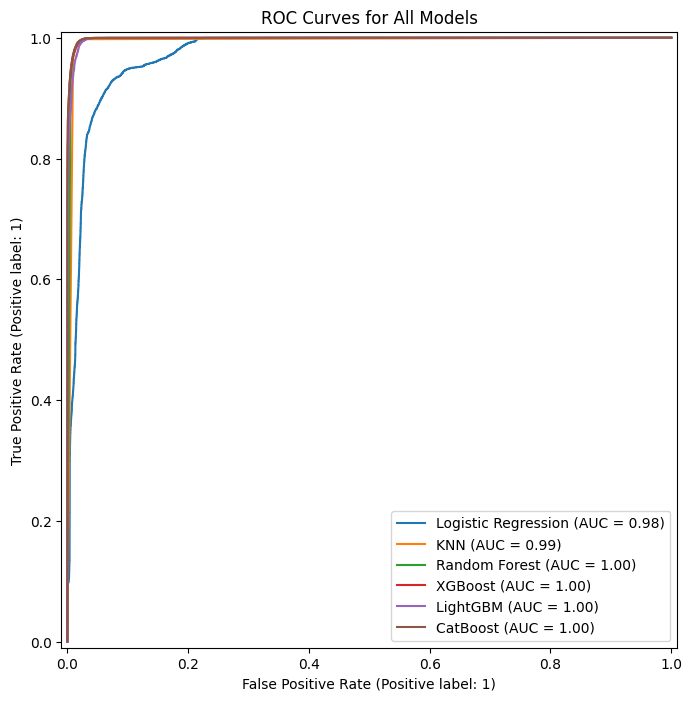

In [77]:
# creating directories for plots
os.makedirs('plots', exist_ok=True)

# looping through all results to handle each model
for results in results_list:
    model = results['model']
    model_name = results['model_name']

    # plotting calibration curve if model supports predict_proba
    if hasattr(model, 'predict_proba'):
        plt.figure(figsize=(6, 6))
        CalibrationDisplay.from_estimator(
            model,
            X_test_pca_full,
            y_test,
            n_bins=10,
            name=model_name
        )
        plt.title(f'{model_name} Calibration Plot')
        plt.tight_layout()
        plt.savefig(f'plots/{model_name.lower().replace(" ", "_")}_calibration_plot.png', dpi=300)
        plt.show()
    else:
        print(f"{model_name} does not support probability calibration curve.")

    # plotting feature importances for tree-based models
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(8, 6))
        importances = model.feature_importances_
        indices = np.argsort(importances)[-10:]  # Top 10 features
        plt.barh(range(len(indices)), importances[indices], color='skyblue', align='center')
        plt.yticks(range(len(indices)), [f'Feature {i+1}' for i in indices])
        plt.xlabel('Relative Importance')
        plt.title(f'{model_name} Feature Importances (Top 10)')
        plt.tight_layout()
        plt.savefig(f'plots/{model_name.lower().replace(" ", "_")}_feature_importances.png', dpi=300)
        plt.show()

    # saving model prediction probabilities
    if results['test_probabilities'] is not None:
        test_probs = pd.DataFrame({
            'True_Label': y_test,
            'Predicted_Prob': results['test_probabilities'][:, 1],
            'KMeans_Cluster': y_test_pca_labels
        })
        file_name = model_name.lower().replace(' ', '_')
        test_probs.to_csv(f'results/{file_name}_predictions.csv', index=False)
        print(f"Saved predictions to results/{file_name}_predictions.csv")

# summarization of results
results_df = pd.DataFrame([{
    'Model': r['model_name'],
    'Val Accuracy': r['val_accuracy'],
    'Val Precision': r['val_precision'],
    'Val Recall': r['val_recall'],
    'Val F1': r['val_f1'],
    'Val ROC AUC': r['val_roc_auc'],
    'Test Accuracy': r['test_accuracy'],
    'Test Precision': r['test_precision'],
    'Test Recall': r['test_recall'],
    'Test F1': r['test_f1'],
    'Test ROC AUC': r['test_roc_auc']
} for r in results_list])

# plotting ROC curves for all models
plt.figure(figsize=(10, 8))
for results in results_list:
    model = results['model']
    model_name = results['model_name']
    if results['test_probabilities'] is not None:
        RocCurveDisplay.from_estimator(
            model,
            X_test_pca_full,
            y_test,
            name=model_name,
            ax=plt.gca()
        )
plt.title('ROC Curves for All Models')
plt.savefig('plots/roc_curves_all_models.png', dpi=300)
plt.show()

In [78]:
def align_cluster_labels(true_labels, cluster_labels):

    cm = confusion_matrix(true_labels, cluster_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)
    label_mapping = {col_ind[i]: i for i in range(len(col_ind))}
    aligned_labels = np.array([label_mapping[label] for label in cluster_labels])
    return aligned_labels

def compute_cluster_metrics(true_labels, predicted_labels, cluster_id):

    binary_pred = (predicted_labels == cluster_id).astype(int)
    binary_true = (true_labels == cluster_id).astype(int)

    metrics = {
        'Cluster': f'Cluster {cluster_id}',
        'Accuracy': accuracy_score(binary_true, binary_pred),
        'Precision': precision_score(binary_true, binary_pred, zero_division=0),
        'Recall': recall_score(binary_true, binary_pred, zero_division=0),
        'F1-Score': f1_score(binary_true, binary_pred, zero_division=0)
    }
    return metrics

def evaluate_cluster_metrics_only(model, model_name, X_train_resampled, y_train_resampled,
                                  X_test_transformed, y_test_true, test_cluster_labels):

    model.fit(X_train_resampled, y_train_resampled)
    y_test_pred = model.predict(X_test_transformed)

    cluster_metrics = []
    for cluster_id in [0, 1]:
        metrics = compute_cluster_metrics(y_test_true, y_test_pred, cluster_id)
        metrics['Model'] = model_name
        cluster_metrics.append(metrics)

        print(f"\nMetrics for {model_name} {metrics['Cluster']}:")
        print(f"Accuracy: {metrics['Accuracy']:.3f}")
        print(f"Precision: {metrics['Precision']:.3f}")
        print(f"Recall: {metrics['Recall']:.3f}")
        print(f"F1-Score: {metrics['F1-Score']:.3f}")

    return cluster_metrics

all_cluster_metrics = []

for model_info in models:
    model = model_info['model']
    model_name = model_info['name']

    print(f"\nEvaluating {model_name} for Cluster Metrics Only")
    cluster_metrics = evaluate_cluster_metrics_only(
        model=model,
        model_name=model_name,
        X_train_resampled=X_res_adasyn,
        y_train_resampled=y_res_adasyn,
        X_test_transformed=X_test_pca_full,
        y_test_true=y_test,
        test_cluster_labels=aligned_test_cluster_labels
    )
    all_cluster_metrics.extend(cluster_metrics)

cluster_metrics_df = pd.DataFrame(all_cluster_metrics)
cluster_metrics_df.to_csv('results/cluster_metrics_summary_only.csv', index=False)

print("\nFinal Cluster Metrics Summary:")
print(cluster_metrics_df)


Evaluating Logistic Regression for Cluster Metrics Only

Metrics for Logistic Regression Cluster 0:
Accuracy: 0.896
Precision: 0.980
Recall: 0.871
F1-Score: 0.922

Metrics for Logistic Regression Cluster 1:
Accuracy: 0.896
Precision: 0.752
Recall: 0.955
F1-Score: 0.841

Evaluating KNN for Cluster Metrics Only

Metrics for KNN Cluster 0:
Accuracy: 0.984
Precision: 0.997
Recall: 0.980
F1-Score: 0.989

Metrics for KNN Cluster 1:
Accuracy: 0.984
Precision: 0.953
Recall: 0.993
F1-Score: 0.973

Evaluating Random Forest for Cluster Metrics Only

Metrics for Random Forest Cluster 0:
Accuracy: 0.986
Precision: 0.995
Recall: 0.985
F1-Score: 0.990

Metrics for Random Forest Cluster 1:
Accuracy: 0.986
Precision: 0.963
Recall: 0.988
F1-Score: 0.975

Evaluating XGBoost for Cluster Metrics Only

Metrics for XGBoost Cluster 0:
Accuracy: 0.978
Precision: 0.999
Recall: 0.969
F1-Score: 0.984

Metrics for XGBoost Cluster 1:
Accuracy: 0.978
Precision: 0.929
Recall: 0.999
F1-Score: 0.963

Evaluating LightG

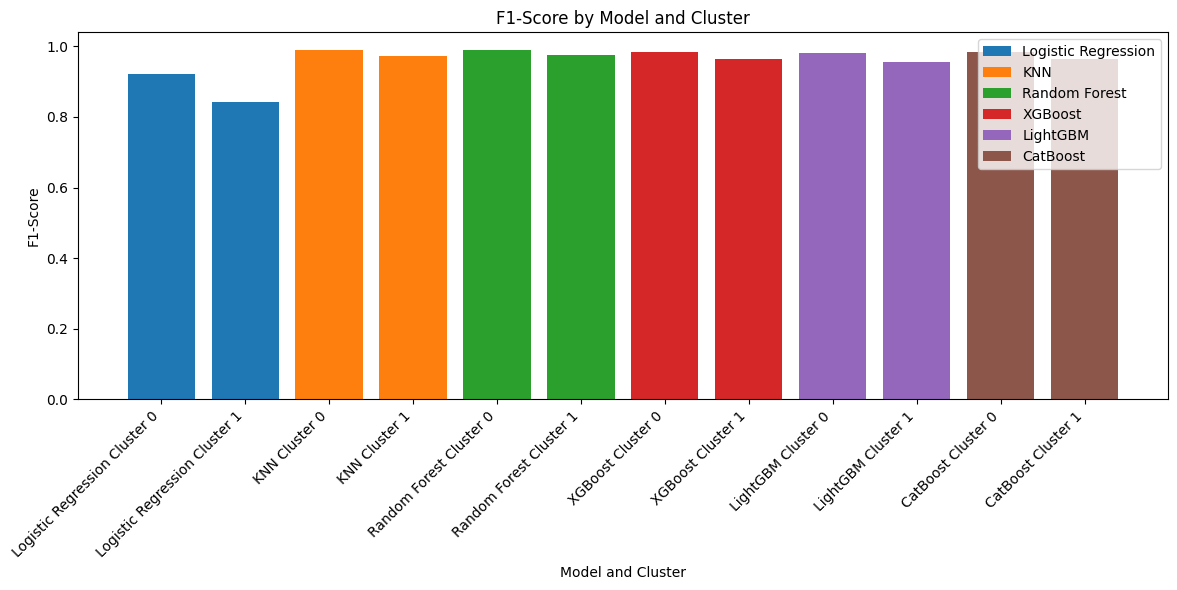

In [79]:
plt.figure(figsize=(12, 6))
for model_name in cluster_metrics_df['Model'].unique():
    model_data = cluster_metrics_df[cluster_metrics_df['Model'] == model_name]
    plt.bar([f"{model_name} {c}" for c in model_data['Cluster']], model_data['F1-Score'], label=model_name)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Model and Cluster')
plt.ylabel('F1-Score')
plt.title('F1-Score by Model and Cluster')
plt.legend()
plt.tight_layout()
plt.savefig('plots/per_cluster_f1_scores.png', dpi=300)
plt.show()